<a href="https://colab.research.google.com/github/ExoticFanta/Master_Thesis/blob/main/EfficientNetB0_28_28.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load the Fashion MNIST dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

# Expand dimensions to fit EfficientNetB0 input format (add channel dimension)
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

# Normalize images to [0, 1] range
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0




29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
def resize_batch(images):
    return tf.map_fn(lambda img: tf.image.resize_with_pad(img, 32, 32), images)

x_train = resize_batch(x_train)
x_test = resize_batch(x_test)

# Convert grayscale images to RGB (EfficientNet expects 3 channels)
x_train = np.repeat(x_train, 3, axis=-1)
x_test = np.repeat(x_test, 3, axis=-1)



In [ ]:
x_val = x_train[-10000:]  # Take the last 10,000 samples
x_train = x_train[:-10000]

y_val = y_train[-10000:]
y_train = y_train[:-10000]

print(x_val.shape)
print(x_train.shape)
print(y_val.shape)
print(y_train.shape)

(10000, 32, 32, 3)
(50000, 32, 32, 3)
(10000,)
(50000,)


In [ ]:
datagen = ImageDataGenerator(
    shear_range=0.2,     # Shear by 20%
    zoom_range=0.2,      # Zoom by 20%
    rotation_range=25,   # Rotate up to 25 degrees
    horizontal_flip=True # Flip images horizontally
)

# Apply Data Augmentation to Training Data
train_generator = datagen.flow(x_train, y_train, batch_size=32)

In [ ]:
# Define EfficientNetB0 model
base_model = keras.applications.EfficientNetB0(
    include_top=False, weights='imagenet', input_shape=(32, 32, 3), pooling='avg'
)
base_model.trainable = False  # Freeze base model

# Add custom classification head
inputs = keras.Input(shape=(32, 32, 3))
x = base_model(inputs, training=False)
x = layers.Dense(280, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(10, activation='softmax')(x)
model = keras.Model(inputs, outputs)

# Compile model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])



16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
# Train model
history = model.fit(train_generator,
                    epochs=15,
                    validation_data=(x_val, y_val))


Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 167s 99ms/step - accuracy: 0.1041 - loss: 2.3160 - val_accuracy: 0.0955 - val_loss: 2.3027
Epoch 2/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 189s 91ms/step - accuracy: 0.0993 - loss: 2.3027 - val_accuracy: 0.0996 - val_loss: 2.3029
Epoch 3/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 141s 90ms/step - accuracy: 0.0970 - loss: 2.3028 - val_accuracy: 0.1023 - val_loss: 2.3028
Epoch 4/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 140s 90ms/step - accuracy: 0.1025 - loss: 2.3027 - val_accuracy: 0.0968 - val_loss: 2.3027
Epoch 5/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 138s 88ms/step - accuracy: 0.0999 - loss: 2.3027 - val_accuracy: 0.1008 - val_loss: 2.3028
Epoch 6/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 143s 91ms/step - accuracy: 0.1015 - loss: 2.3027 - val_accuracy: 0.0996 - val_loss: 2.3029
Epoch 7/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 142s 91ms/step - accuracy: 0.0971 - loss: 2.3027 - val_accuracy: 0.1021 - val_loss: 2.3026
Epoch 8/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 142s 91ms/step - accuracy: 0.0981 - lo

In [ ]:
# Evaluate model
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print(f"Test accuracy: {test_acc:.4f}")

313/313 - 18s - 57ms/step - accuracy: 0.1000 - loss: 2.3026
Test accuracy: 0.1000


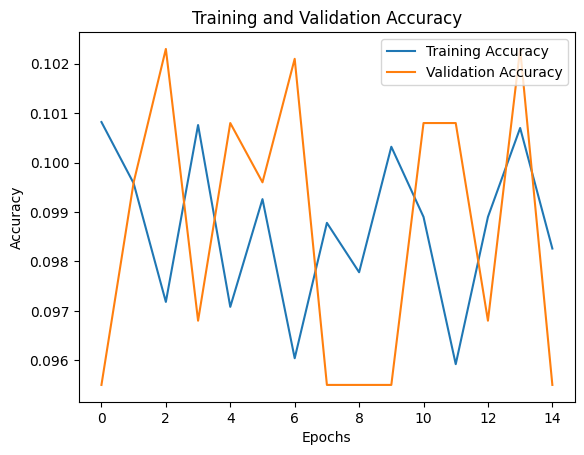

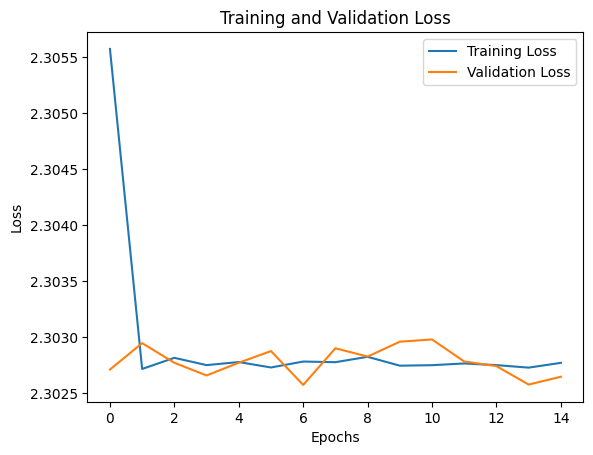

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import classification_report

y_pred = model.predict(x_test)  # Get predicted probabilities
y_pred_labels = np.argmax(y_pred, axis=1)  # Convert to class labels

# Generate Classification Report
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_labels, digits=4))

313/313 ━━━━━━━━━━━━━━━━━━━━ 23s 63ms/step

Classification Report:

              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000      1000
           1     0.0000    0.0000    0.0000      1000
           2     0.0000    0.0000    0.0000      1000
           3     0.0000    0.0000    0.0000      1000
           4     0.0000    0.0000    0.0000      1000
           5     0.0000    0.0000    0.0000      1000
           6     0.0000    0.0000    0.0000      1000
           7     0.1000    1.0000    0.1818      1000
           8     0.0000    0.0000    0.0000      1000
           9     0.0000    0.0000    0.0000      1000

    accuracy                         0.1000     10000
   macro avg     0.0100    0.1000    0.0182     10000
weighted avg     0.0100    0.1000    0.0182     10000



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
